# Setup
Because we switch to `tf2`, instead of using `tf.slim`, we will just use `tf.keras` for the inception model weights.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image

from tqdm.notebook import tqdm

In [28]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

DARK_READER = True
if DARK_READER:
    plt.rcParams.update({
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "black",
        "axes.facecolor": "black",
        "axes.edgecolor": "lightgray",
        "axes.labelcolor": "white",
        "axes.titlecolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "lightgray",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black",
    })

In [29]:
import tensorflow as tf
import tensorflow.keras as keras
tf.__version__, keras.__version__

('2.5.0', '2.5.0')

In [30]:
inception_model = keras.applications.inception_v3.InceptionV3()
inception_model, type(inception_model)

(<tensorflow.python.keras.engine.functional.Functional at 0x7f52e0110ad0>,
 tensorflow.python.keras.engine.functional.Functional)

In [31]:
isinstance(inception_model, keras.Model)

True

In [32]:
def non_dunder(obj, strict=False):
    if strict:
        prefix = "_"
    else:
        prefix = "__"
    return [s for s in dir(obj) if not s.startswith(prefix)]

In [33]:
inception_model.trainable = False
inception_model.trainable

False

In [34]:
inception_model.trainable_weights, inception_model.trainable_variables

([], [])

In [35]:
inception_model.layers[0].input.shape

TensorShape([None, 299, 299, 3])

In [36]:
import numpy as np

In [37]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [38]:
def inception(image):
    if isinstance(image, tf.Variable):
        #image.assign(preprocess_input(image.numpy()))
        pass
    elif isinstance(image, np.ndarray) and image.dtype == np.uint8:
        image = preprocess_input(image)
    
    if len(image.shape) == 3:
        image_batch = tf.expand_dims(image, axis=0)
    
    #if image.dtype is np.uint8:
    #    image = image.astype(np.float32)
    #if image.dtype is tf.uint8:
    #    image = tf.cast(image, tf.float32)
    #image = preprocess_input(image)
    return inception_model(image_batch)[0]

In [39]:
import json
from pathlib import Path
from urllib.request import urlretrieve

In [40]:
imagenet_json = Path("imagenet.json")
if not imagenet_json.exists():
    imagenet_json, _ = urlretrieve(
        'https://www.anishathalye.com/media/2017/07/25/imagenet.json',
        imagenet_json,
    )

with open(imagenet_json) as f:
    imagenet_labels = json.load(f)
imagenet_labels

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

In [41]:
len(imagenet_labels)

1000

In [42]:
img_path = Path("cat.jpg")
if not img_path.exists():
    img_path, _ = urlretrieve(
        'https://www.anishathalye.com/media/2017/07/25/cat.jpg',
        img_path
    )
img_class = 281
imagenet_labels[img_class]

'tabby, tabby cat'

In [43]:
img = Image.open(img_path)
#big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
#img = (np.asarray(img) / 255.0).astype(np.float32)
#img = np.asarray(img, dtype=np.float32)
img = np.asarray(img)
img.shape, img.dtype, img.max(), img.min()

((299, 299, 3), dtype('uint8'), 255, 0)

In [44]:
def classify(img, correct_class=None, target_class=None, k=10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)  # sca() Select Current Axis
    ax1.imshow(img)
    #p = inception_model(np.expand_dims(img, axis=0))[0]
    p = inception(img)
    p = p.numpy()
    #print(f"type(p) = {type(p)}, len(p) = {len(p)}")
    
    #fig.sca(ax1)  # Why should there be two fig.sca(ax1)?
    
    # display the top 10 prediceted classes
    #topk = list(p.argsort()[-10:][::-1])
    #topk = list(tf.argsort(p)[-10:][::-1])
    #k = 20
    topk = list((tf.argsort(p)[-k:][::-1]).numpy())
    #print(f"topk = {topk}")
    topprobs = p[topk]
    barlist = ax2.bar(range(k), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(k),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    # :15 means "taking the first 15 characters" for fear of long-string class.
    fig.subplots_adjust(bottom=0.2)
    plt.show()

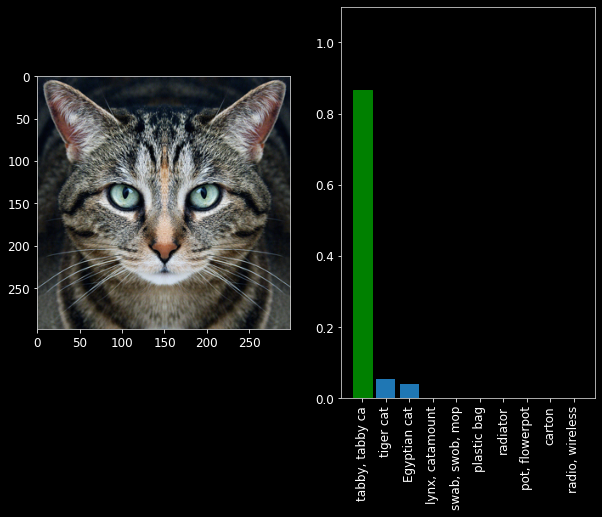

In [45]:
classify(img, correct_class=img_class)

In [46]:
isinstance(tf.Variable(10), tf.Tensor)

False

In [47]:
isinstance(tf.Variable(10), tf.Variable)

True

In [48]:
def inverse_preprocess(array, uint8=False):
    return (array + 1) / 2

# Adversarial examples

Given an image $\mathbf{x}$, our neural network outputs a probability distribution over labels, $P(y \mid \mathbf{x})$. When we craft an adversarial input, we want to find an $\hat{\mathbf{x}}$ where $\log P(\hat{y} \mid \hat{\mathbf{x}})$ is maximized for a target label $\hat{y}$: that way, our input will be misclassified as the target class. We can ensure that $\hat{\mathbf{x}}$ doesn't look too different from the original $\mathbf{x}$ by constraining ourselves to some $\ell_\infty$ <del>box</del> ball with radius $\epsilon$, requiring that $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$.

In this framework, an adversarial example is the solution to a constrained optimization problem that we can solve using [backpropagation](https://colah.github.io/posts/2015-08-Backprop/) and projected gradient descent, basically the same techniques that are used to train networks themselves. The algorithm is simple:

We begin by initializing our adversarial example as $\hat{\mathbf{x}} \leftarrow \mathbf{x}$. Then, we repeat the following until convergence:

1. $\hat{\mathbf{x}} \leftarrow \hat{\mathbf{x}} + \alpha \cdot \nabla \log P(\hat{y} \mid \hat{\mathbf{x}})$
2. $\hat{\mathbf{x}} \leftarrow \mathrm{clip}(\hat{\mathbf{x}}, \mathbf{x} - \epsilon, \mathbf{x} + \epsilon)$

In [49]:
#image = tf.Variable(img, dtype=tf.float32)
image = tf.Variable(tf.zeros((299,299,3), dtype=tf.float32))
x_hat = image

x_hat.dtype, x_hat.shape

(tf.float32, TensorShape([299, 299, 3]))

In [50]:
demo_epsilon = 2.0/255.0 # a really small perturbation
# Test other target classes at your own will
#demo_target = imagenet_labels.index("pizza, pizza pie")
demo_target = imagenet_labels.index("desktop computer")
demo_epsilon, demo_target

(0.00784313725490196, 527)

In [51]:
img_processed = keras.applications.inception_v3.preprocess_input(img)
below = img_processed - demo_epsilon
below = np.clip(below, -1, 1)
above = img_processed + demo_epsilon
above = np.clip(above, -1, 1)
print(f"img[:2, :2, 0] =\n{img[:2, :2, 0]}\n")
print(f"img_processed[:2, :2, 0] =\n{img_processed[:2, :2, 0]}\n")
print(f"below[:2, :2, 0] =\n{below[:2, :2, 0]}\n")
print(f"above[:2, :2, 0] =\n{above[:2, :2, 0]}")

img[:2, :2, 0] =
[[14 14]
 [15 16]]

img_processed[:2, :2, 0] =
[[-0.8901961  -0.8901961 ]
 [-0.88235295 -0.8745098 ]]

below[:2, :2, 0] =
[[-0.8980392  -0.8980392 ]
 [-0.8901961  -0.88235295]]

above[:2, :2, 0] =
[[-0.88235295 -0.88235295]
 [-0.8745098  -0.8666667 ]]


In [52]:
demo_lr = 1e-1
demo_steps = 100

# projected gradient descent
for i in tqdm(range(demo_steps)):
    ## gradient descent step
    #_, loss_value = sess.run(
    #    [optim_step, loss],
    #    feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    ## project step
    #sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    with tf.GradientTape() as tape:
        #tape.watch(x_hat)
        #proba = inception(x_hat)[demo_target]
        probas = inception(x_hat)
        loss = keras.losses.sparse_categorical_crossentropy(demo_target, probas)
        #loss = keras.losses.sparse_categorical_crossentropy([demo_target], [proba])
        #log_likelihood = inception(image)[tf.constant(1)]
        
    grad = tape.gradient(loss, [x_hat])[0]
    #print(f"grad.shape = {grad.shape}")
    #print(f"demo_lr*grad = {type(demo_lr*grad)}")
    #tf.Variable.assign_add(x_hat, demo_lr*grad)
    
    #x_hat.assign_add(demo_lr*grad)
    #x_hat.assign_sub(demo_lr*grad)
    
    #x_hat.assign_add(demo_lr*grad.numpy())
    #x_hat = x_hat + demo_lr*grad
    projected = tf.clip_by_value(
        tf.clip_by_value(x_hat - demo_lr*grad, below, above),
        -1, 1)
    #projected = tf.clip_by_value(x_hat + demo_lr * grad, below, above)
    #tf.Variable.assign(x_hat, projected)
    x_hat.assign(projected)
    
    if (i+1) % 10 == 0:
        print(f'step{i+1: 4d}, loss={loss:.6f}, proba={probas[demo_target].numpy():.6f}')

  0%|          | 0/100 [00:00<?, ?it/s]

step  10, loss=7.364683, proba=0.000633
step  20, loss=5.993431, proba=0.002495
step  30, loss=5.313797, proba=0.004923
step  40, loss=4.772011, proba=0.008463
step  50, loss=4.347112, proba=0.012944
step  60, loss=3.992121, proba=0.018461
step  70, loss=3.687208, proba=0.025042
step  80, loss=3.429519, proba=0.032403
step  90, loss=3.221476, proba=0.039896
step 100, loss=2.995216, proba=0.050026


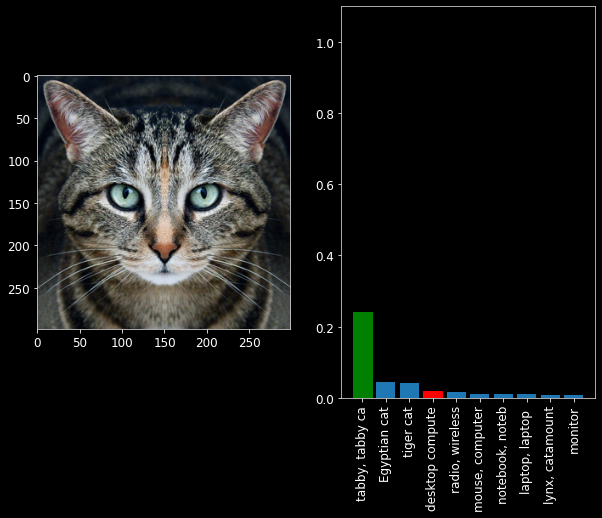

In [60]:
classify(
    (inverse_preprocess(x_hat.numpy()) * 255).astype(np.uint8),
    #inverse_preprocess(x_hat.numpy()),
    correct_class=img_class,
    target_class=demo_target
)

In [55]:
probas[demo_target]

<tf.Tensor: shape=(), dtype=float32, numpy=0.05002581>

In [61]:
imagenet_labels.index("Egyptian cat")

285

In [62]:
probas[imagenet_labels.index("Egyptian cat")]

<tf.Tensor: shape=(), dtype=float32, numpy=0.025739914>

In [59]:
demo_target, img_class

(527, 281)

In [65]:
tf.sort(probas, direction="DESCENDING")[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.12328403, 0.05002581, 0.02573991, 0.02450114, 0.02115966,
       0.01935675, 0.01694031, 0.0144507 , 0.01277901, 0.01170273],
      dtype=float32)>

In [63]:
def top(array, k=10):
    return [imagenet_labels[index] for index in tf.argsort(probas, direction="DESCENDING")[:k]]

In [64]:
top(probas)

['tabby, tabby cat',
 'desktop computer',
 'Egyptian cat',
 'tiger cat',
 'radio, wireless',
 'notebook, notebook computer',
 'laptop, laptop computer',
 'mouse, computer mouse',
 'monitor',
 'screen, CRT screen']

In [ ]:
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

In [ ]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

First, we set up the input image. We use a `tf.Variable` instead of a `tf.placeholder` because we will need it to be trainable. We can still feed it when we want to.

In [ ]:
image = tf.Variable(tf.zeros((299, 299, 3)))

Next, we load the Inception v3 model.

In [ ]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

logits, probs = inception(image, reuse=False)

The `preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)` line, I guess, was just to make the output real numbers lying in $[-1, 1]$ instead of $[0, 1]$.

Next, we load pre-trained weights. This Inception v3 has a top-5 accuracy of 93.9%.

In [ ]:
import tempfile
from urllib.request import urlretrieve
#from urllib import urlretrieve
import tarfile
import os

In the original notebook, the url of the following cell were `https` but I don't know why it does not work any more; instead, one has to replace `https` by `http`.

In [ ]:
data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)

**(?1)**
- `urlretrieve()`'s return value
- `tarfile.open`'s return value

In [ ]:
data_dir

In [ ]:
ls $data_dir

In [ ]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

Next, we write some code to show an image, classify it, and show the classification result.

In [ ]:
import json
import matplotlib.pyplot as plt

In [ ]:
imagenet_json, _ = urlretrieve(
    'https://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [ ]:
imagenet_json

In [ ]:
imagenet_labels

In [ ]:
type(imagenet_labels), len(imagenet_labels)

In [ ]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)  # sca() Select Current Axis
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)  # Why should there be two fig.sca(ax1)?
    
    # display the top 10 prediceted classes
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    # :15 means "taking the first 15 characters" for fear of long-string class.
    fig.subplots_adjust(bottom=0.2)
    plt.show()

In [ ]:
L = ["a", "b", "c"]
L.index("c"), L.index("b"), #L.index("z")

## Example image

We load our example image and make sure it's classified correctly.

In [ ]:
import PIL
import numpy as np

In [ ]:
img_path, _ = urlretrieve('https://www.anishathalye.com/media/2017/07/25/cat.jpg')
img_class = 281
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

**(?)** What is the `new_w, new_h, resize()` all about?<br>
**(R)** The story was that Anish wanted to `crop((0,0,299,299))`, i.e. crop the `299x299` subimage for the upper left corner for each image. But the reality is that _**not every image has both width and height larger than**_ `299`. So the `resize((new_w, new_h))` was there to guarantee this. Indeed,
\begin{align}
  h_{\text{new}} = 299,\;  w_{\text{new}} = h_{\text{new}} \frac{w}{h} \quad\text{when}\quad h < w \\
  w_{\text{new}} = 299,\;  h_{\text{new}} = w_{\text{new}} \frac{h}{w} \quad\text{when}\quad h \ge w
\end{align}

which converted into words says **_always convert the shorter side to_** `299` and **_the longer side to its rightful length according to the original ratio_**.

In [ ]:
imagenet_labels[img_class]

In [ ]:
classify(img, correct_class=img_class)

# Adversarial examples

Given an image $\mathbf{x}$, our neural network outputs a probability distribution over labels, $P(y \mid \mathbf{x})$. When we craft an adversarial input, we want to find an $\hat{\mathbf{x}}$ where $\log P(\hat{y} \mid \hat{\mathbf{x}})$ is maximized for a target label $\hat{y}$: that way, our input will be misclassified as the target class. We can ensure that $\hat{\mathbf{x}}$ doesn't look too different from the original $\mathbf{x}$ by constraining ourselves to some $\ell_\infty$ <del>box</del> ball with radius $\epsilon$, requiring that $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$.

In this framework, an adversarial example is the solution to a constrained optimization problem that we can solve using [backpropagation](https://colah.github.io/posts/2015-08-Backprop/) and projected gradient descent, basically the same techniques that are used to train networks themselves. The algorithm is simple:

We begin by initializing our adversarial example as $\hat{\mathbf{x}} \leftarrow \mathbf{x}$. Then, we repeat the following until convergence:

1. $\hat{\mathbf{x}} \leftarrow \hat{\mathbf{x}} + \alpha \cdot \nabla \log P(\hat{y} \mid \hat{\mathbf{x}})$
2. $\hat{\mathbf{x}} \leftarrow \mathrm{clip}(\hat{\mathbf{x}}, \mathbf{x} - \epsilon, \mathbf{x} + \epsilon)$

## Initialization

We start with the easiest part: writing a TensorFlow op for initialization.

In [ ]:
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

## Gradient descent step

Next, we write the gradient descent step to maximize the log probability of the target class (or equivalently, minimize the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy)).

In [ ]:
type(())  # empty tuple as the shape of a float

In [ ]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])

**N.B.** `logits` was defined in an earlier cell, via `image`, which should probably viewed as identical to `x_hat`.

**(?)** The `var_list` param of `minimize()`

## Projection step

Finally, we write the projection step to keep our adversarial example visually close to the original image. Additionally, we clip to $[0, 1]$ to keep it a valid image.

In [ ]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    # cf. p.323 ageron's homl1e
    project_step = tf.assign(x_hat, projected)

**(?)** What would happen if we do not use `tf.control_dependencies()` here?

## Execution

Finally, we're ready to synthesize an adversarial example. We arbitrarily choose "guacamole" (imagenet class 924) as our target class.

In [ ]:
imagenet_labels.index("pizza, pizza pie")

In [ ]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = 924 # "guacamole"
# Test other target classes at your own will
demo_target = imagenet_labels.index("pizza, pizza pie")


# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example

**Rmk.**
- Took several minutes to finish running `100` steps on Thinkpad X200.
- [%g](https://stackoverflow.com/questions/30658919/the-precision-of-printf-with-specifier-g)
- Note that `image` and `x_hat` really are regarded as identical in the TensorFlow graph above, because
  - `project_step` assigns the projection to `x_hat`
  - Optimization updates `image`
  - They have to be the same thing in order for this to work.

This adversarial image is visually indistinguishable from the original, with no visual artifacts. However, it's classified as "guacamole" with high probability!

In [ ]:
classify(adv, correct_class=img_class, target_class=demo_target)

**(?)** How small was the perturbation `2.0/255.0`? Try to do an experiment with random noise of that magnitude of perturbation.

**Stopped here (2021/02/19 (金) 16h04)**

This adv attack is very cool, but we haven't verified that the weights we downloaded really classify the imagenet images well. Let's do this.

In [ ]:
tf.__version__

It seems that one cannot use `tfds` in `tensorflow==1.13.1`.<br>
`pip` seems to download ok, but cannot run.

# Robust adversarial examples

Now, we go through a more advanced example. We follow our approach for [synthesizing robust adversarial examples](https://arxiv.org/abs/1707.07397) to find a single perturbation of our cat image that's simultaneously adversarial under some chosen distribution of transformations.  We could choose any distribution of differentiable transformations; in this post, we'll synthesize a single adversarial input that's robust to rotation by $\theta \in [-\pi/4, \pi/4]$.

Before we proceed, let's check if our previous example is still adversarial if we rotate it, say by an angle of $\theta = \pi/8$.

In [ ]:
ex_angle = np.pi/8

angle = tf.placeholder(tf.float32, ())
rotated_image = tf.contrib.image.rotate(image, angle)
rotated_example = rotated_image.eval(feed_dict={image: adv, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

Looks like our original adversarial example is not rotation-invariant! Let's try one more.

In [ ]:
rotated_example = rotated_image.eval(feed_dict={image: adv, angle: -np.pi/4})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

So, how do we make an adversarial example robust to a distribution of transformations? Given some distribution of transformations $T$, we can maximize $\mathbb{E}_{t \sim T} \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$, subject to $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$. We can solve this optimization problem via projected gradient descent, noting that $\nabla \mathbb{E}_{t \sim T} \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$ is $\mathbb{E}_{t \sim T} \nabla \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$ and approximating with samples at each gradient descent step.

Rather than manually implementing the gradient sampling, we can use a trick to get TensorFlow to do it for us: we can model our sampling-based gradient descent as doing gradient descent over an ensemble of stochastic classifiers that randomly sample from the distribution and transform their input before classifying it.

**(?)** Why does Anish keep speak of **distribution of transformations**?

In [ ]:
num_samples = 10
average_loss = 0
for i in range(num_samples):
    rotated = tf.contrib.image.rotate(
        image, tf.random_uniform((), minval=-np.pi/4, maxval=np.pi/4))
    rotated_logits, _ = inception(rotated, reuse=True)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=labels) / num_samples

**(?)** What is `reuse=True` here? It means that we reuse the weights we've found before?

**(?)** Why `average_loss` has to be divided by `num_samples` here?

**(?)** Why in the last `tf.nn.softmax_cross_entropy_with_logits()` we had `labels=[labels]` while in this one we have `labels=labels`?

We can reuse our `assign_op` and `project_step`, though we'll have to write a new `optim_step` for this new objective.

In [ ]:
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(average_loss, var_list=[x_hat])

Finally, we're ready to run PGD to generate our adversarial input. As in the previous example, we'll choose "guacamole" as our target class.

In [ ]:
demo_epsilon = 8.0/255.0 # still a pretty small perturbation
demo_lr = 2e-1
demo_steps = 300
demo_target = 924 # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 50 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv_robust = x_hat.eval() # retrieve the adversarial example

This adversarial image is classified as "guacamole" with high confidence, even when it's rotated!

In [ ]:
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
#rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: np.random.uniform(-np.pi/4, np.pi/4)})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

## Evaluation

Let's examine the rotation-invariance of the robust adversarial example we produced over the entire range of angles, looking at $P(\hat{y} \mid \hat{\mathbf{x}})$ over $\theta \in [-\pi/4, \pi/4]$.

In [ ]:
thetas = np.linspace(-np.pi/4, np.pi/4, 301)

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={image: adv_robust, angle: theta})
    p_robust.append(probs.eval(feed_dict={image: rotated})[0][demo_target])
    
    rotated = rotated_image.eval(feed_dict={image: adv, angle: theta})
    p_naive.append(probs.eval(feed_dict={image: rotated})[0][demo_target])

robust_line, = plt.plot(thetas, p_robust, color='b', linewidth=2, label='robust')
naive_line, = plt.plot(thetas, p_naive, color='r', linewidth=2, label='naive')
plt.ylim([0, 1.05])
plt.xlabel('rotation angle')
plt.ylabel('target class probability')
plt.legend(handles=[robust_line, naive_line], loc='lower right')
plt.show()

It's super effective!

## Challenge
It would be a good challenge to write this same notebook using
- `tf2`
- `torch`, etc.